In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad

        out._backward = _backward
        return out
    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward
      return out

    def __rmul__(self, other):
      return self * other

    def tanh(self):
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
        self.grad += (1- t**2) * out.grad

      out._backward = _backward
      return out

    def __pow__(self, other):
      x = self.data
      other = other if isinstance(other, (int, float)) else other.data
      t = x**other
      out = Value(t, (self, ), f'**{other}')

      def _backward():
        self.grad += other * x**(other-1) * out.grad
      out._backward = _backward

      return out

    def __truediv__(self, other):
      return self * (other**-1)

    def __neg__(self):
      return self * -1

    def __sub__(self, other):
      return self + (-other)
    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)
      self.grad = 1.0

      for node in reversed(topo):
        node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = "L"
L

Value(data=-8.0)

In [ ]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [ ]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

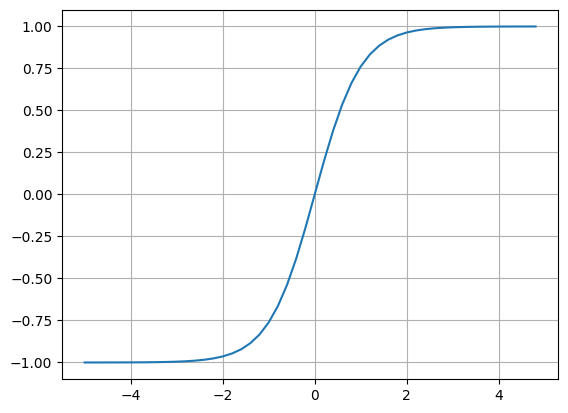

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

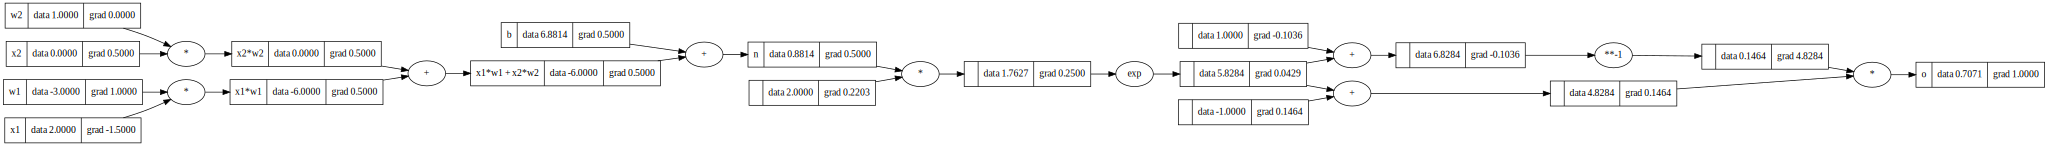

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

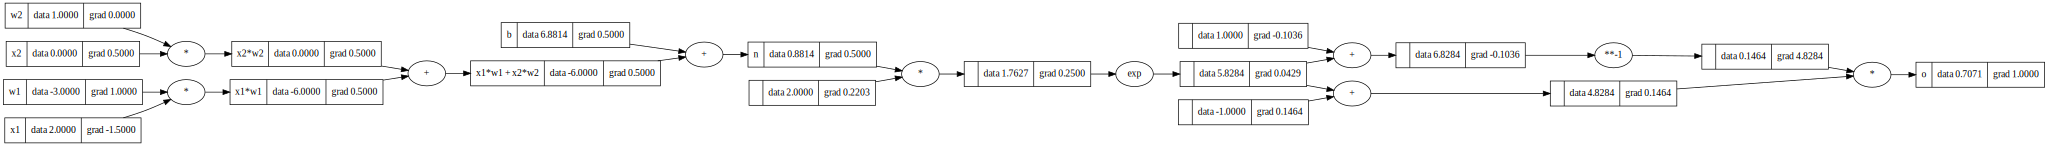

In [ ]:
draw_dot(o)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [ ]:
import torch

In [ ]:
#leaf nodes generally don't want gradients because they're inputs!! only care about gradients of our thetas

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
x2.grad.item

<function Tensor.item>

In [ ]:
import random

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    #2*x+b
    zip(self.w, x)

    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return[p for layer in self.layers for p in layer.parameters()]



In [ ]:
n = MLP(3,[4,4,1])

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [ ]:
for k in range(40):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = [(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]
  loss = sum(loss, start = Value(0))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(f"Epoch: {k} | Loss: {loss.data}")

Epoch: 0 | Loss: 7.999398654614531
Epoch: 1 | Loss: 7.802926894535957
Epoch: 2 | Loss: 7.629013339191813
Epoch: 3 | Loss: 7.378280111043888
Epoch: 4 | Loss: 6.8880375253432415
Epoch: 5 | Loss: 5.669064923245264
Epoch: 6 | Loss: 3.0061425897096976
Epoch: 7 | Loss: 1.7867034223847553
Epoch: 8 | Loss: 1.1488859012194297
Epoch: 9 | Loss: 0.6890355615975546
Epoch: 10 | Loss: 0.4356577990627918
Epoch: 11 | Loss: 0.30178724264715984
Epoch: 12 | Loss: 0.22523404601478464
Epoch: 13 | Loss: 0.17734645507899677
Epoch: 14 | Loss: 0.14514768924258603
Epoch: 15 | Loss: 0.1222530073181316
Epoch: 16 | Loss: 0.10525143094928127
Epoch: 17 | Loss: 0.09218568206132341
Epoch: 18 | Loss: 0.08186383532031291
Epoch: 19 | Loss: 0.07352343381969215
Epoch: 20 | Loss: 0.06665633945028382
Epoch: 21 | Loss: 0.0609120229471878
Epoch: 22 | Loss: 0.05604148331253535
Epoch: 23 | Loss: 0.05186332914826468
Epoch: 24 | Loss: 0.048242503343373155
Epoch: 25 | Loss: 0.0450765083350274
Epoch: 26 | Loss: 0.042286236076979844
E

In [ ]:
ypred

[Value(data=0.9343592303315705),
 Value(data=-0.9650770016589932),
 Value(data=-0.9075778420572806),
 Value(data=0.9046794197490581)]